# Predicting PM2.5 levels for five Chinese cities
#### Analysis by Michał Szałański, 2023

In [57]:
from IPython.display import HTML

HTML('''
     <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.6.3/jquery.min.js"></script>
     
     <script>
        code_show = true; 
        function code_toggle() {
            if (code_show){
                $('.jp-CodeCell .jp-Cell-inputWrapper').hide();
            } else {
                $('.jp-CodeCell .jp-Cell-inputWrapper').show();
            }
            code_show = !code_show
        } 
        $( document ).ready(code_toggle);
    </script>
    The code for this notebook is by default hidden for easier reading. To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
    
    <style>
        body {
            max-width: 900px !important;
            margin: auto !important; 
        }
    </style>
''')

# Goal of the analysis

Create a simple regression model that will predict the next day levels of PM2.5 particle matter in five Chinese cities, based on historical data, and weather variables.    
Source of the data: [link](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

# Exploratory data analysis
### Mean levels of PM2.5 in five Chinese cities
Running 30-day average added to analyze the trend. Distribution of the variable in each city is similar - values of around 90, with high variance and spikes as high as 1 000. Comparing year by year there is no trend, however the data indicates yearly seasonality, which will be analyzed on the next plot. 

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # seaborn warning about not using data=... notation
import seaborn as sns

import os

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

sns.set(rc = {'figure.figsize':(12, 5)})
plt.rcParams['figure.dpi'] = 150

In [9]:
def loadRawData():
    # Loading each csv into the list and concat them into one dataframe in one step 
    df = []

    for file in os.listdir('data'):
        temp = pd.read_csv(
            f'data/{file}', 
            parse_dates = {'date': ['year', 'month', 'day', 'hour']}, 
            date_parser = lambda x: datetime.strptime(x, '%Y %m %d %H'),
            keep_date_col = True # will be used as dummies
        )

        # Values for different stations in each city are simmilar, so we can take the mean of them 
        targetCols = [col for col in temp.columns if 'PM' in col]
        temp['meanPM'] = temp[targetCols].mean(axis=1).round(2)

        targetCols.extend(('No', 'Iprec'))
        temp.drop(targetCols, axis=1, inplace=True)

        # Adding the source of the data from the filename
        temp['source'] = file.split('PM')[0]
        df.append(temp)

    df = pd.concat(df, axis = 0)

    # Moving important columns to the front, will be usefull when categorical columns are converted to dummies
    colsToMove = ['date', 'source', 'meanPM']
    df = df[colsToMove + [col for col in df.columns if col not in colsToMove]]
    df['dayOfWeek'] = df['date'].dt.dayofweek

    df = df[df.date > datetime(2012, 1, 1)]
    
    # Replace invalid values with NaN
    df.DEWP          = df.DEWP.replace(-9999, np.nan)
    df.DEWP          = df.DEWP.replace(-97, np.nan)

    df.HUMI          = df.HUMI.replace(-9999, np.nan)
    df.precipitation = df.precipitation.replace(999990, np.nan)

    return df.reset_index(drop = True)

df = loadRawData()

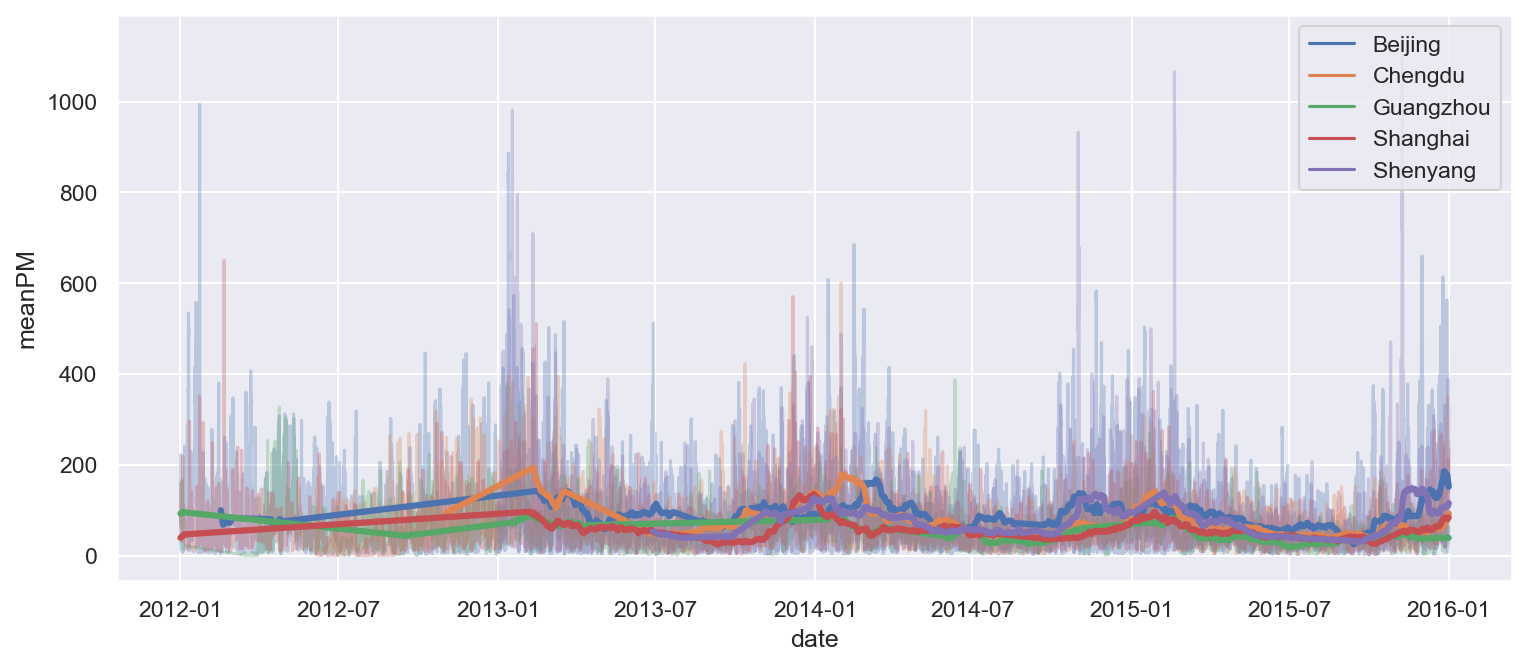

In [44]:
ax = sns.lineplot(data = df, x = 'date', y = 'meanPM', hue = 'source', alpha = 0.3)
ax = sns.lineplot(df.date, df.meanPM.rolling(24*30).mean(), hue = df.source, alpha = 1, legend = False, linewidth = 3)
ax = plt.legend(loc = 'upper right')

### Examining the seasonality of the dependent variable in each city
Daily seasonality is mixed - three cities experience it mildly, while two do not. Weekly and month seasonality is not present. As expected, yearly seasonality is strong, with values as high as 160 in January, and as low as 40 in July. 

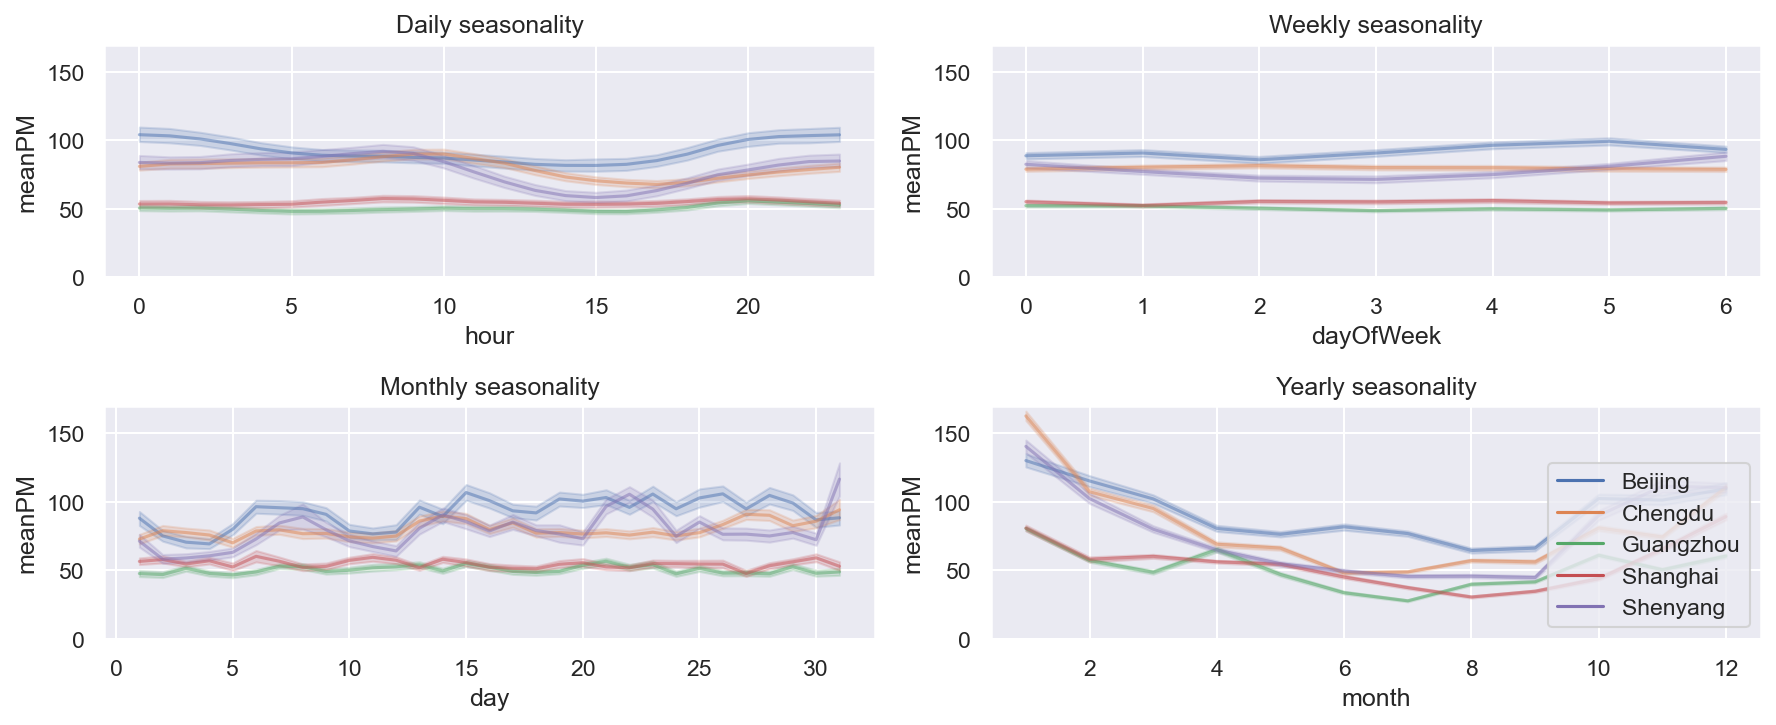

In [32]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 5), dpi = 150)

seasonality = {
    'hour'      : 'Daily seasonality',
    'dayOfWeek' : 'Weekly seasonality',
    'day'       : 'Monthly seasonality',
    'month'     : 'Yearly seasonality', 
}

for i, (col, title) in enumerate(seasonality.items()):
    sns.lineplot(x = df[col].astype(int), y = df.meanPM, hue = df.source, alpha = 0.5, ax = axs[i//2, i%2]).set(title = title, ylim = (0, 170))
        
handles, labels = axs[1, 1].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))

plt.show()

### Independent variables - time and city
Hour variables experience yearly seasonality - Dew Point, Pressure, Temperature and Precipitation. Cumulated wind speed is more random, present mostly in two cities. Distribution of the Humidity in percent is very complex, as can be expected, since the maximal humidity is dependent also on the temperature. 

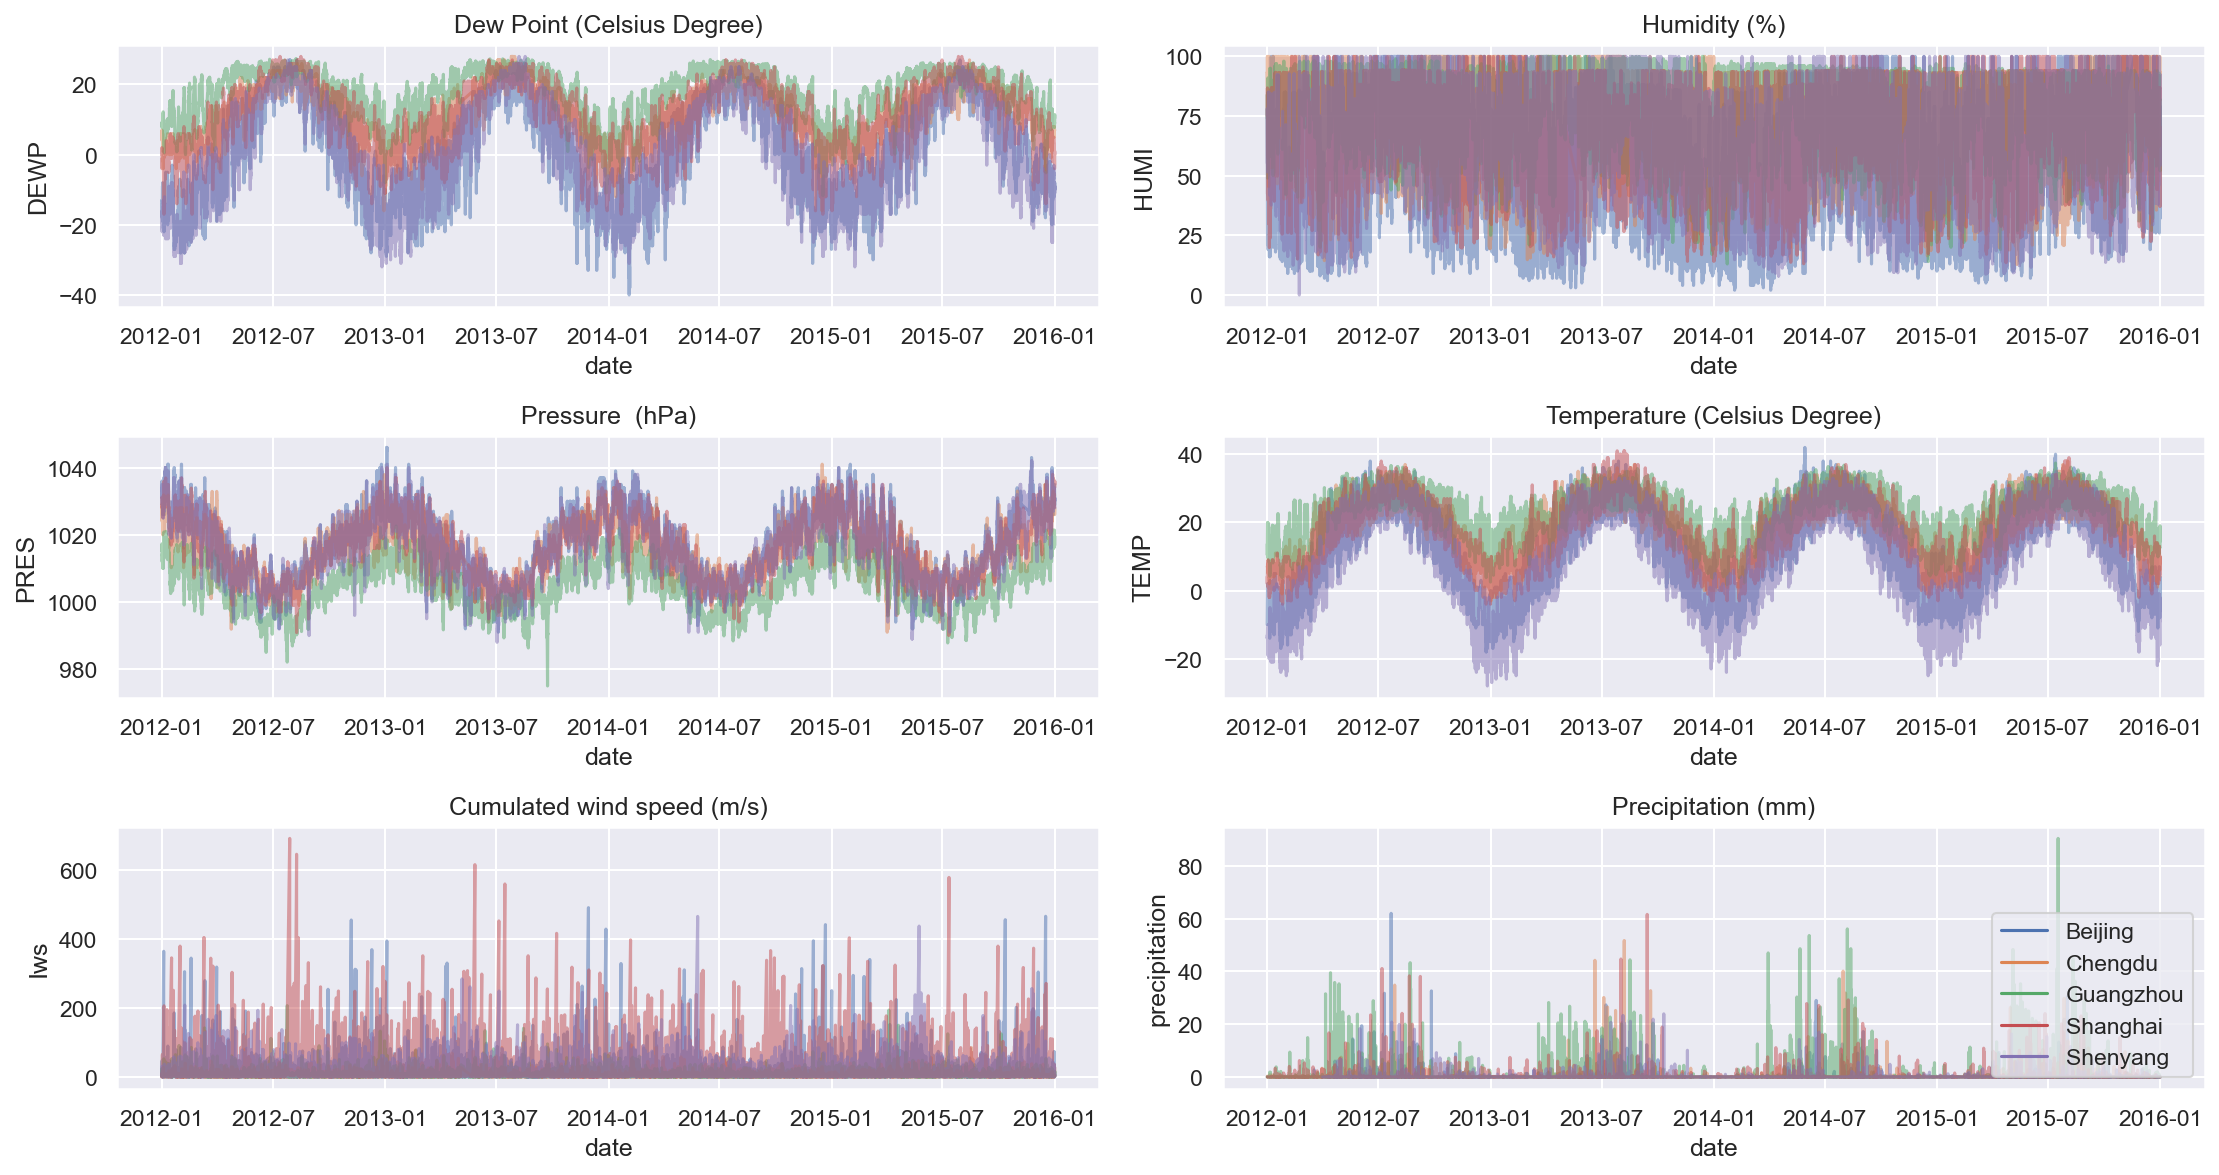

In [33]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 8), dpi = 150)

independentVariables = {
    'DEWP'           : 'Dew Point (Celsius Degree)',
    'HUMI'           : 'Humidity (%)',
    'PRES'           : 'Pressure  (hPa)', 
    'TEMP'           : 'Temperature (Celsius Degree)', 
    'Iws'            : 'Cumulated wind speed (m/s)', 
    'precipitation'  : 'Precipitation (mm)',
}

for i, (col, title) in enumerate(independentVariables.items()):
    sns.lineplot(data = df, x = 'date', y = col, hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title)
    
handles, labels = axs[0, 0].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))

plt.show()


### Other remarks about the data
* Analyzed period shortened to 2012 - 2015, since only one city had data for 2010 and 2011. 
* After shortening, the data consists of a total of 175 315 observations for 5 Chinese cities, each with a mean PM2.5 value and eight weather related variables.
* The dependent variable has 10% missing values, precipitation 4%, while for other variables the number of missing values in negligible.  

# Regression

### Data wrangling and assumptions
* Since missing values in independent variables are rare, they are forward filled (with backfill in case the missing value is the first one).
* Independent variables regarding weather were lagged 24h, since at the time of prediction they would not have been known. Missing this step would introduce the look-ahead bias. 
* Based on the seasonality analysis, the lagged PM2.5 was added, with lags of 24 hours and 365 days. 
* Categorical variables, including the city, month, day, day of the week and hour were added as one hot encoded dummies. 
* Last year (2015) was used as the test set, since a standard random train/test split would introduce information leakage due to lagged variables.
* All numerical variables, including the dependent variable, were standardized. The scaler was trained on the test set, and then used to transform the entire dataset, to avoid information leakage. 
* Lastly, rows containing at least one missing value were dropped. This accounted for 35% of the dataset. While this is a high percent of the dataset, the remaining size is still large enough to train a ML model. Missing values were mostly due to original 10% missing in the dependent variable, lagging of this variable, and the use of a one year lag (in effect the entire 2012 was dropped).

In [47]:
def prepareTrainTestSet():
    df = loadRawData()

    ### Fill missing values in independent variables ###
    colsToFill = df.columns.to_list()
    colsToFill.remove('meanPM')

    # Missing values in the independent variables are rare, so they are just filled with the previous value
    df[colsToFill] = df[colsToFill].fillna(method = 'ffill').fillna(method = 'bfill')


    ### Lagging the variables ###
    independentCols = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation']
    df[independentCols] = df[independentCols].shift(24) # 24 hours lag

    df['meanPM_24h']  = df.groupby('source').shift(24).meanPM
    df['meanPM_365d'] = df.groupby('source').shift(24 * 365).meanPM # later this sadly drops the first year of data
    

    ### Convert categorical to dummies ###
    catCols = ['source', 'month', 'day', 'hour', 'season', 'cbwd', 'dayOfWeek']
    temp = [df.drop(catCols, axis = 1)]
    temp.extend(pd.get_dummies(df[col], prefix = col) for col in catCols)
    df = pd.concat(temp, axis = 1)
    
    
    ### Designate last year (~20%) of the data as test set ###
    df['isTestSet'] = (df.date > datetime(2015, 1, 1)).astype(int)
    
    
    ### Scale the numerical columns ###
    numCols = ['meanPM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'meanPM_24h', 'meanPM_365d']
    
    scaler = StandardScaler()
    scaler.fit(df[df.isTestSet == 0][numCols])
    
    df[numCols] = scaler.transform(df[numCols])
    
    
    ### Drop rows with NaN values ###
    # 35% of the dataset is dropped. This is just a quick analysis so it's ok
    # In a production model, the missing values should be investigated and filled with more sophisticated methods
    # e.g. using a moving average (although the gaps are wider than 24 hours, so it's not ideal)
    droppedRows = df.isnull().any(axis = 1).sum()
    percentOfTotal = (droppedRows / df.shape[0] * 100).round(2)
    #print(f'Dropping {droppedRows} ({percentOfTotal}%) rows with NaN')
    
    df = df[~df.isnull().any(axis = 1)].reset_index(drop = True)


    ### Drop unnecessary columns ###
    df = df.drop(['date', 'year'], axis = 1)


    ### Split the data into train and test sets ###
    independentCols = [col for col in df.columns if col not in ['meanPM', 'isTestSet']]
    
    X_train = df[df.isTestSet == 0][independentCols]
    X_test  = df[df.isTestSet == 1][independentCols]
    
    y_train = df[df.isTestSet == 0]['meanPM']
    y_test  = df[df.isTestSet == 1]['meanPM']

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepareTrainTestSet()

### Model results
For the regression, a random forest model was chosen, because of its good predictive power and resistance to overfitting.   
The model was trained on the train set, and evaluated on the test set. It achieved a R^2 result of 0.3757, which is a fair score, although it certainly could be improved.  

In [48]:
regRF = RandomForestRegressor(n_estimators = 500, max_depth = 10, random_state = 42, verbose = 0, n_jobs = -1)
regRF.fit(X_train, y_train)
score = regRF.score(X_test, y_test).round(4)
print(f'Random Forest score: {score}')

Random Forest score: 0.3757


### Feature importance (top 10)
Based on the estimated model, the most important variables can be determined. Overall, the lagged dependent variable (24h and yearly), Dew Point and the Pressure account for 61% of the predictive power. 

In [50]:
(pd.Series(regRF.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(10) * 100).round(2)

meanPM_24h        42.54
DEWP               8.09
PRES               7.18
meanPM_365d        3.61
cbwd_cv            2.98
source_Beijing     2.74
cbwd_NW            2.69
HUMI               2.04
TEMP               1.86
Iws                1.84
dtype: float64

# Possible future improvements 
The estimated model performance could be improved in a number of ways, for example by: 
* Estimating a number of different models (e.g. NN, SVR, XGBoost, ARIMA) and selecting the best one.
* Fine tuning the model hyperparameters using cross-validation (although it typically only nets improvements of 2-3%).
* Creating a way to fill at least some of the missing values, instead of dropping them.
* Adding an additional data source, e.g. public holidays (lower emissions from industry) or energy usage (PM2.5 generated by the coal power plants).